# Interface of `policy`

Let's install the latest version of Poutyne (if it's not already) and import all the needed packages. For the first section discussing the `policy` API, only the Poutyne import is necessary.

In [1]:
%pip install --upgrade poutyne

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18

from poutyne import Model, OptimizerPolicy, linspace, cosinespace, one_cycle_phases

## About `policy`

[`Policies`](https://poutyne.org/callbacks.html#module-poutyne.policies) give you fine-grained control over the training process.
This notebook demonstrates how [`policies`](https://poutyne.org/callbacks.html#module-poutyne.policies) work and how you can create your own policies.

### Parameter Spaces and Phases

Parameter spaces like `linspace` and `cosinespace` are the basic building blocks. You can define the space and iterate over them:

In [2]:
space = linspace(1, 0, 3)
for i in space:
    print(i)

1.0
0.5
0.0


In [3]:
space = cosinespace(1, 0, 5)
for i in space:
    print(i)

1.0
0.8535533905932737
0.5
0.14644660940672627
0.0


You can use the space and create a phase with them:

In [4]:
from poutyne import Phase

phase = Phase(lr=linspace(0, 1, 3))

# and iterate
for d in phase:
    print(d)

{'lr': 0.0}
{'lr': 0.5}
{'lr': 1.0}


You can also visualize your phase:

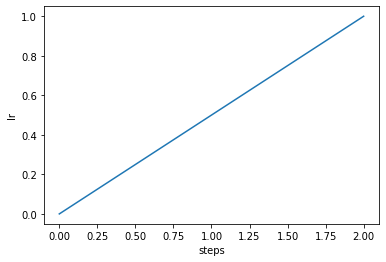

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

phase.plot("lr");

Phases can have multiple parameters:

<AxesSubplot:xlabel='steps', ylabel='momentum'>

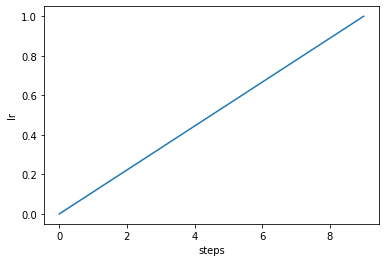

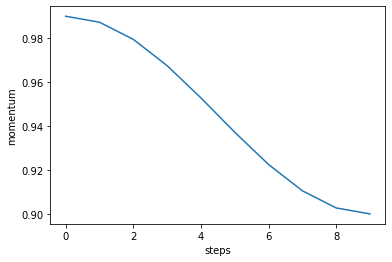

In [6]:
phase = Phase(
    lr=linspace(0, 1, 10),
    momentum=cosinespace(0.99, 0.9, 10),
)

phase.plot("lr")
phase.plot("momentum")

### Visualize Different Phases

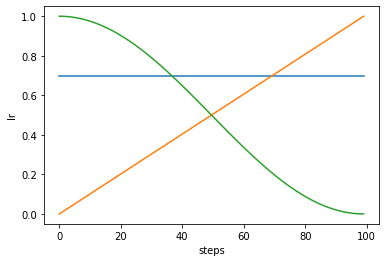

In [7]:
steps = 100

fig, ax = plt.subplots()
# Constant value
Phase(lr=linspace(0.7, 0.7, steps)).plot(ax=ax)
# Linear
Phase(lr=linspace(0, 1, steps)).plot(ax=ax)
# Cosine
Phase(lr=cosinespace(1, 0, steps)).plot(ax=ax);

### Visualize Multiple Parameters in One Phase

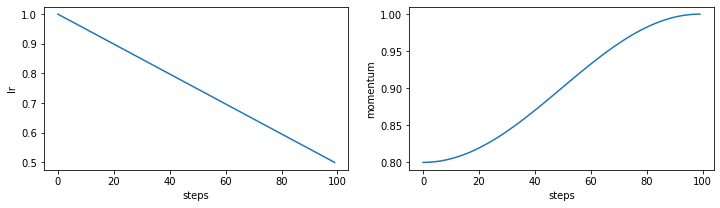

In [8]:
steps = 100
phase = Phase(lr=linspace(1, 0.5, steps), momentum=cosinespace(0.8, 1, steps))

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
phase.plot("lr", ax=axes[0])
phase.plot("momentum", ax=axes[1]);

## Build Complex Policies From Basic Phases

You can build complex optimizer policies by chaining phases together:

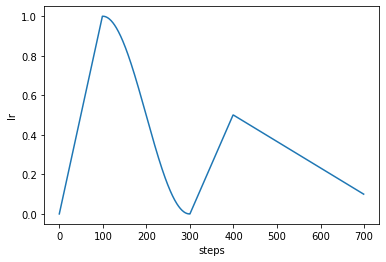

In [9]:
from poutyne import OptimizerPolicy

policy = OptimizerPolicy(
    [
        Phase(lr=linspace(0, 1, 100)),
        Phase(lr=cosinespace(1, 0, 200)),
        Phase(lr=linspace(0, 0.5, 100)),
        Phase(lr=linspace(0.5, 0.1, 300)),
    ]
)

policy.plot();

### Use Already Defined Complex Policies

It's easy to build your own policies, but Poutyne contains some pre-defined phases.

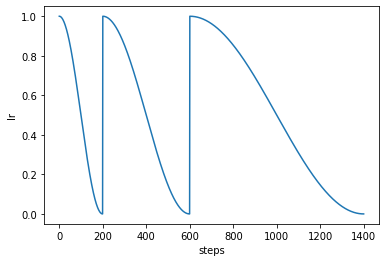

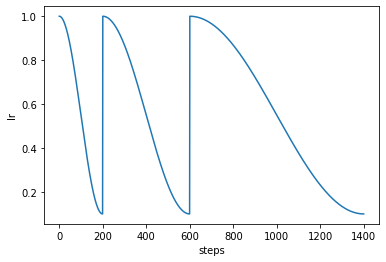

In [10]:
from poutyne import sgdr_phases

# build them manually
policy = OptimizerPolicy(
    [
        Phase(lr=cosinespace(1, 0, 200)),
        Phase(lr=cosinespace(1, 0, 400)),
        Phase(lr=cosinespace(1, 0, 800)),
    ]
)
policy.plot()

# or use the pre-defined one
policy = OptimizerPolicy(sgdr_phases(base_cycle_length=200, cycles=3, cycle_mult=2))
policy.plot();

Pre-defined ones are just a list phases:

In [11]:
sgdr_phases(base_cycle_length=200, cycles=3, cycle_mult=2)

[Phase:
     lr: <poutyne.framework.callbacks.policies.cosinespace object at 0x7ff1d9caa7c0>,
 Phase:
     lr: <poutyne.framework.callbacks.policies.cosinespace object at 0x7ff1d9caa640>,
 Phase:
     lr: <poutyne.framework.callbacks.policies.cosinespace object at 0x7ff1d9caa5b0>]

Here is the one-cycle policy:

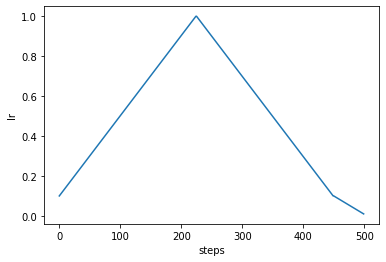

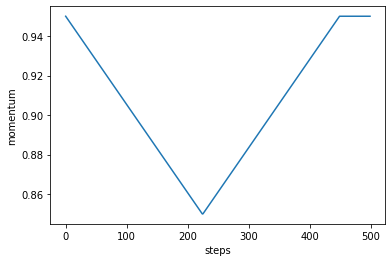

In [12]:
from poutyne import one_cycle_phases

tp = OptimizerPolicy(one_cycle_phases(steps=500))
tp.plot("lr")
tp.plot("momentum");

## Train CIFAR With the `policy` Module

### Training constant

But first, let's set the training constants, the CUDA device used for training if one is present, we set the batch size (i.e. the number of elements to see before updating the model) and the number of epochs (i.e. the number of times we see the full dataset).

In [13]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

batch_size = 1024
epochs = 5

### Load the Data

In [14]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

In [15]:
root = "datasets"
train_dataset = datasets.CIFAR10(root, train=True, transform=train_transform, download=True)
valid_dataset = datasets.CIFAR10(root, train=False, transform=valid_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

### The Model
We'll train a simple `ResNet-18` network.
This takes a while without GPU but is pretty quick with GPU.

In [17]:
def get_network():
    model = resnet18(pretrained=False)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    model.fc = nn.Linear(512, 10)
    return model

### Training Without the `policies` Module

In [18]:
network = get_network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01)

model = Model(
    network,
    optimizer,
    criterion,
    batch_metrics=["acc"],
    device=device,
)

history = model.fit_generator(
    train_loader,
    valid_loader,
    epochs=epochs,
)

Epoch: 1/5 Train steps: 49 Val steps: 10 8.50s loss: 2.117267 acc: 22.938000 val_loss: 1.897823 val_acc: 31.520000
Epoch: 2/5 Train steps: 49 Val steps: 10 8.37s loss: 1.807276 acc: 34.258000 val_loss: 1.663334 val_acc: 39.370000
Epoch: 3/5 Train steps: 49 Val steps: 10 8.33s loss: 1.648168 acc: 39.900000 val_loss: 1.558678 val_acc: 43.060000
Epoch: 4/5 Train steps: 49 Val steps: 10 8.33s loss: 1.551231 acc: 43.308000 val_loss: 1.476921 val_acc: 46.160000
Epoch: 5/5 Train steps: 49 Val steps: 10 8.41s loss: 1.488462 acc: 45.990000 val_loss: 1.419701 val_acc: 48.160000


### Training With the `policies` Module

In [19]:
steps_per_epoch = len(train_loader)
steps_per_epoch

49

In [20]:
network = get_network()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.01)

model = Model(
    network,
    optimizer,
    criterion,
    batch_metrics=["acc"],
    device=device,
)

policy = OptimizerPolicy(
    one_cycle_phases(epochs * steps_per_epoch, lr=(0.01, 0.1, 0.008)),
)
history = model.fit_generator(
    train_loader,
    valid_loader,
    epochs=epochs,
    callbacks=[policy],
)

Epoch: 1/5 Train steps: 49 Val steps: 10 8.44s loss: 1.811203 acc: 34.102000 val_loss: 1.787274 val_acc: 42.180000
Epoch: 2/5 Train steps: 49 Val steps: 10 8.51s loss: 1.424713 acc: 49.248000 val_loss: 1.422221 val_acc: 49.880000
Epoch: 3/5 Train steps: 49 Val steps: 10 8.47s loss: 1.161917 acc: 58.934000 val_loss: 1.088061 val_acc: 61.350000
Epoch: 4/5 Train steps: 49 Val steps: 10 8.44s loss: 0.962621 acc: 65.860000 val_loss: 0.978735 val_acc: 65.970000
Epoch: 5/5 Train steps: 49 Val steps: 10 8.45s loss: 0.816820 acc: 71.280000 val_loss: 0.883923 val_acc: 69.270000
